In [4]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch import optim
from torch import nn

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
ticker = "AAPL"
df = yf.download(ticker, start="2015-01-01", end="2025-01-01")

/var/folders/fw/fg0_f2fx5tn55v9k_2zxd6d00000gn/T/ipykernel_40573/3186649856.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

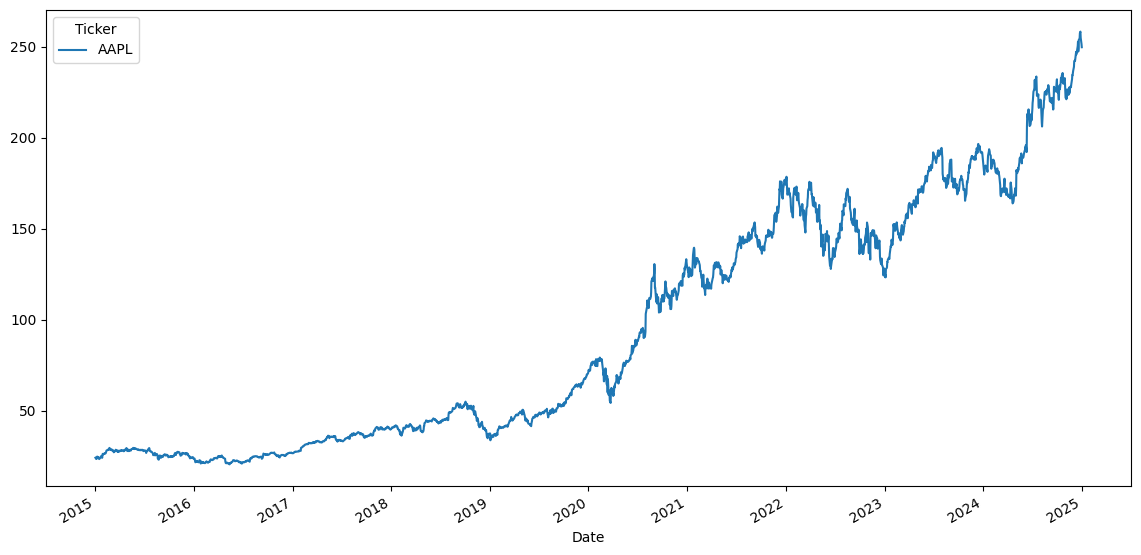

In [11]:
df.Close.plot(figsize=(14, 7))

In [15]:
scaler = StandardScaler()

df.Close = scaler.fit_transform(df.Close)

df.Close

Ticker,AAPL
Date,
2015-01-02,-1.064087
2015-01-05,-1.074523
2015-01-06,-1.074489
2015-01-07,-1.069441
2015-01-08,-1.055413
...,...
2024-12-24,2.494007
2024-12-26,2.506483
2024-12-27,2.454295


In [50]:
seq_length = 30

deta = []

for i in range(len(df.Close) - seq_length):
    deta.append(df.Close[i:i + seq_length + 1].values)
    
data = np.array(deta)
train_size = int(len(data) * 0.8)

x_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
x_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [51]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        
        return out

In [52]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [53]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [54]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(x_train)
    
    loss = criterion(y_train_pred, y_train)
    
    if i % 25 == 0:
        print(i, loss.item())
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.5815057754516602
25 0.011686882004141808
50 0.002180275972932577
75 0.001573379384353757
100 0.0014137555845081806
125 0.0013302243314683437
150 0.001260325312614441
175 0.0012036903062835336


In [55]:
model.eval()

y_test_pred = model(x_test)

y_train_pred = scaler.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scaler.inverse_transform(y_train.cpu().detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scaler.inverse_transform(y_test.cpu().detach().numpy())

In [56]:
from sklearn.metrics import root_mean_squared_error

train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [57]:
train_rmse

0.03407438099384308

In [58]:
test_rmse

0.17538970708847046

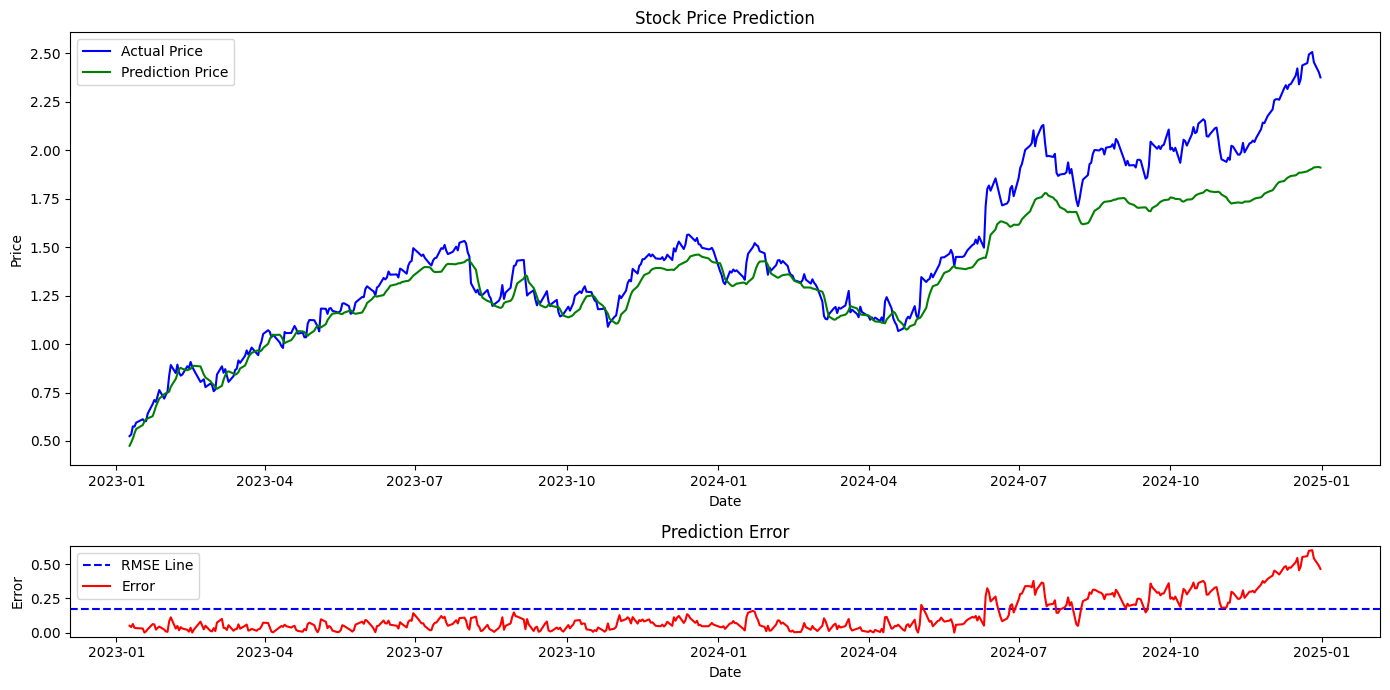

In [65]:
fig = plt.figure(figsize=(14, 7))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color='blue', label='Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color='green', label='Prediction Price')
ax1.legend()
plt.title(f"Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE Line')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), color='red', label='Error')
ax2.legend()
plt.title("Prediction Error")
plt.xlabel("Date")
plt.ylabel("Error")

plt.tight_layout()
plt.show()